In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
import shap
from sklearn.model_selection import learning_curve, cross_val_score
import warnings

In [50]:
warnings.filterwarnings(action='ignore', category=UserWarning, module='LightGBM')
df = pd.read_csv('product_data.csv')

In [51]:
df

,product_id,product_type,timestamp,actual_price,promotional_price,competitor1,competitor2,competitor3,competitor4,competitor5,competitor6,competitor7,competitor8,competitor9,competitor10
0,product1,electronics,1.718599e+09,1413.86,1224.30,1251.19,1269.74,1310.96,1337.50,1205.94,1266.77,1263.79,1399.98,1284.61,1304.23
1,product2,headphones,1.718573e+09,346.85,299.38,341.17,301.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product3,beverages,1.718539e+09,2.47,2.10,2.42,2.16,2.42,2.27,2.44,2.43,2.29,2.40,2.39,2.43
3,product4,beverages,1.718508e+09,1.13,0.96,1.07,1.04,1.03,1.05,1.10,NaN,NaN,NaN,NaN,NaN
4,product5,smartphones,1.718497e+09,617.34,527.41,524.79,582.33,604.97,553.51,546.57,577.31,583.88,529.86,592.11,541.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,product996,headphones,1.674122e+09,153.78,136.97,137.72,131.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,product997,smartphones,1.674039e+09,620.15,529.28,564.97,540.74,549.48,557.77,548.65,534.21,532.65,539.18,591.07,542.85
997,product998,headphones,1.674004e+09,194.34,166.98,184.06,181.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,product999,smartphones,1.673970e+09,1096.65,941.11,1042.84,1042.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
## Label Encoding


# Example: Label encoding for product_id and competitor_id
# label_encoder = LabelEncoder()

# df['product_id'] = label_encoder.fit_transform(df['product_id'])

# # Optionally, you can also encode product_type if it's categorical
# df['product_type'] = label_encoder.fit_transform(df['product_type'])

# # Check the encoded columns
# print(df[['product_id',  'product_type']].head())

In [53]:
# ##  One-Hot Encoding

# one_hot_encoder = OneHotEncoder(sparse=False)

# # Fit-transform the data and add new columns to the DataFrame
# product_type_encoded = one_hot_encoder.fit_transform(df[['product_type']])
# product_type_encoded_df = pd.DataFrame(product_type_encoded, columns=one_hot_encoder.get_feature_names(['product_type']))

# # Concatenate with original DataFrame
# df = pd.concat([df, product_type_encoded_df], axis=1)

# # Drop original categorical column (if needed)
# df.drop(columns=['product_type'], inplace=True)

# # Check the encoded DataFrame
# print(df.head())

In [54]:
# Fill missing values with a placeholder (e.g., -1) for competitor columns
# for col in features.columns:
#     if 'competitor' in col:
#         features[col].fillna(-1, inplace=True)  # Fill missing competitor prices with -1 or any other appropriate placeholder

# features = features.fillna(features.mean())

competitor_columns = [col for col in df.columns if col.startswith('competitor')][:5]

# Fill NaN values in competitor columns with the mean of that row
# df['competitor_mean'] = df[competitor_columns].mean(axis=1)

# print(df.head())
# for col in competitor_columns:
#     df[col].fillna(df['competitor_mean'], inplace=True)

# df.drop(columns=['competitor_mean'], inplace=True)

df[competitor_columns] = df[competitor_columns].apply(lambda x: x.fillna(x.mean()), axis=1)
df['max_discount'] = np.round(df['actual_price'] - df[competitor_columns].min(axis=1), 2)

df['min_price'] = df[competitor_columns].min(axis=1)

# keep only 5 competitors
other_columns = [col for col in df.columns if not col.startswith('competitor')]
keep_columns = other_columns + competitor_columns

df_final = df[keep_columns]
# Feature engineering: Extract relevant features and target
features = df_final.drop(columns=['product_id', 'product_type', 'timestamp', 'promotional_price'])
target = df_final['promotional_price']  # Target variable: actual price

print(features)

     actual_price  max_discount  min_price  competitor1  competitor2  \
0         1413.86        207.92    1205.94      1251.19      1269.74   
1          346.85         45.14     301.71       341.17       301.71   
2            2.47          0.31       2.16         2.42         2.16   
3            1.13          0.10       1.03         1.07         1.04   
4          617.34         92.55     524.79       524.79       582.33   
..            ...           ...        ...          ...          ...   
995        153.78         22.09     131.69       137.72       131.69   
996        620.15         79.41     540.74       564.97       540.74   
997        194.34         12.86     181.48       184.06       181.48   
998       1096.65         54.36    1042.29      1042.84      1042.29   
999        144.38         20.23     124.15       138.06       124.22   

     competitor3  competitor4  competitor5  
0       1310.960     1337.500     1205.940  
1        321.440      321.440      321.440  


In [55]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

base_model = lgb.LGBMRegressor(verbosity=-1)

print(X_test)

# Fit the model
base_model.fit(X_train, y_train)

# Make predictions
y_pred = base_model.predict(X_test)

# Train the quantile regression models for lower and upper bounds
min_price_model = lgb.LGBMRegressor(objective='quantile', alpha=0.1)
max_price_model = lgb.LGBMRegressor(objective='quantile', alpha=0.9)

min_price_model.fit(X_train, y_train)
max_price_model.fit(X_train, y_train)

# Predict the quantiles
lower_bound_pred = min_price_model.predict(X_test)
upper_bound_pred = max_price_model.predict(X_test)


     actual_price  max_discount  min_price  competitor1  competitor2  \
521        219.93         22.45     197.48       197.48       197.89   
737        282.14         34.30     247.84       270.82       269.75   
740        289.15         38.25     250.90       276.68       250.90   
660          1.23          0.11       1.12         1.21         1.22   
411          1.25          0.17       1.08         1.08         1.11   
..            ...           ...        ...          ...          ...   
408        643.53         87.18     556.35       592.29       556.35   
332        584.09         80.21     503.88       503.88       526.11   
208        250.38         36.82     213.56       238.00       225.50   
613        135.54         13.25     122.29       128.37       132.29   
78         282.75         32.94     249.81       254.83       278.25   

     competitor3  competitor4  competitor5  
521      217.850      200.630      207.330  
737      264.930      247.840      262.720  


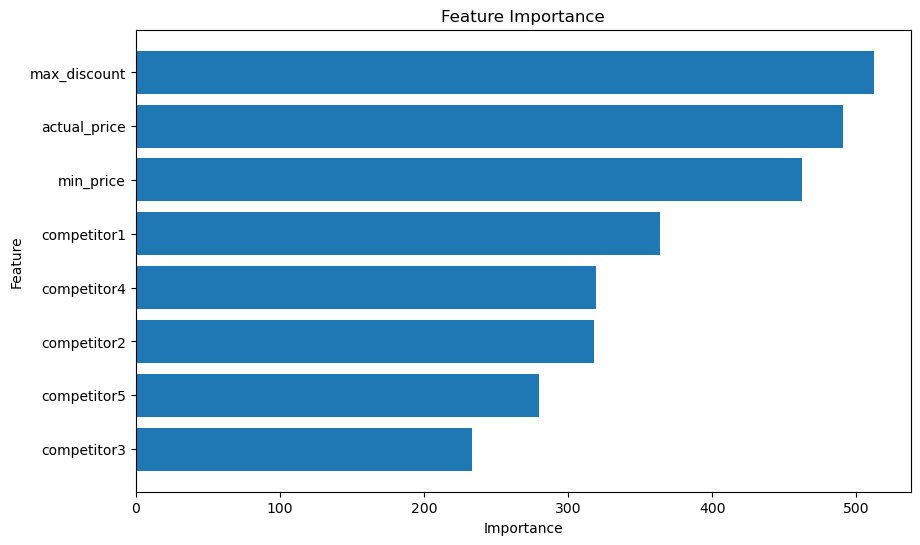

In [56]:
feature_importances = base_model.feature_importances_
feature_names = features.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


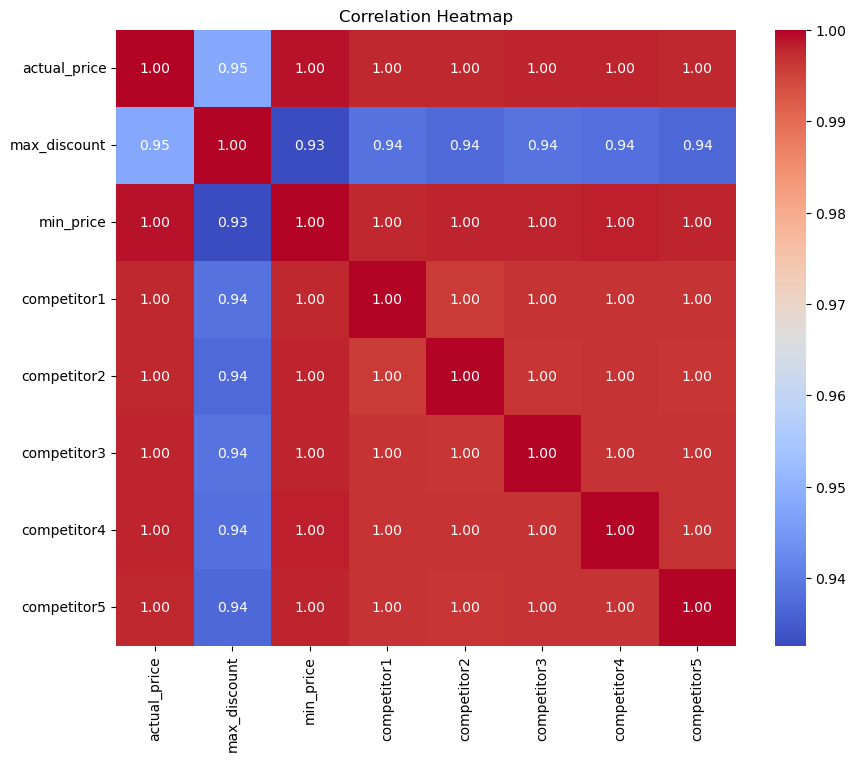

In [57]:
# HEAT MAP

# Compute the correlation matrix
corr = features.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

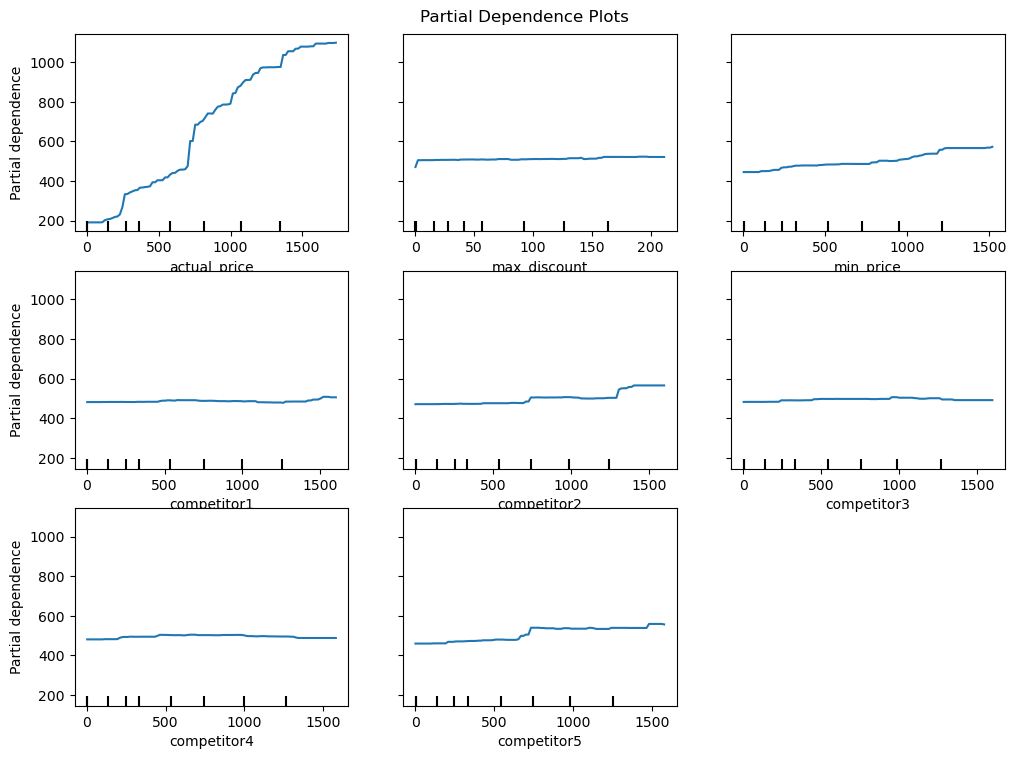

In [58]:
# Partial Dependence Plots (PDP)

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(base_model, X_train, features.columns, ax=ax)
plt.suptitle('Partial Dependence Plots')
plt.subplots_adjust(top=0.95)
plt.show()

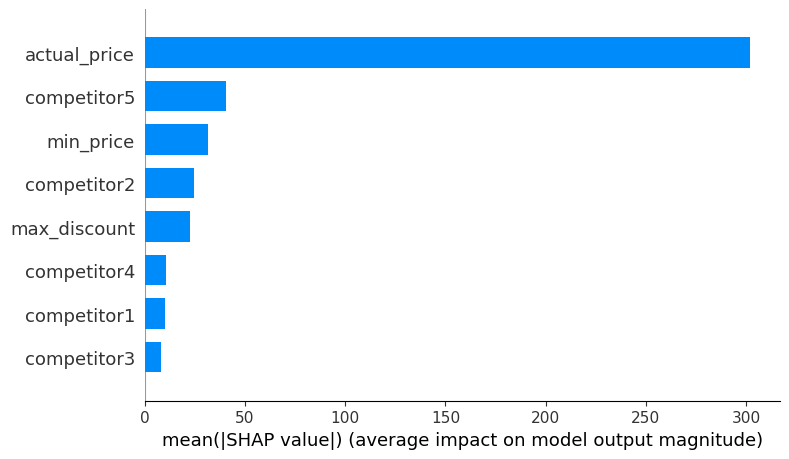

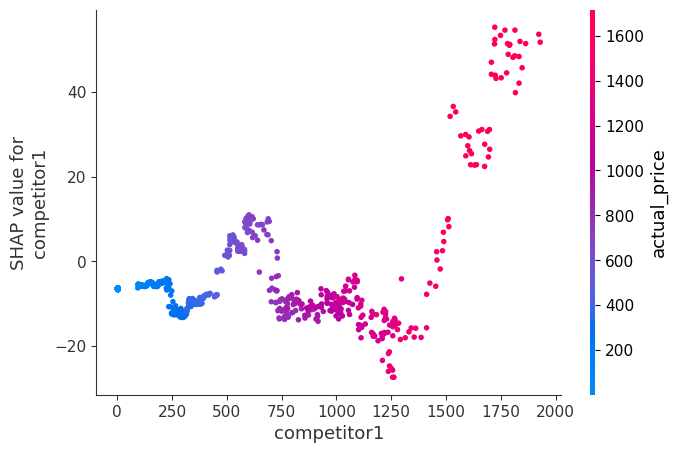

In [59]:
## SHAP Value

# Create a SHAP explainer
explainer = shap.TreeExplainer(base_model)
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

# SHAP dependence plot for a single feature
shap.dependence_plot('competitor1', shap_values, X_train)

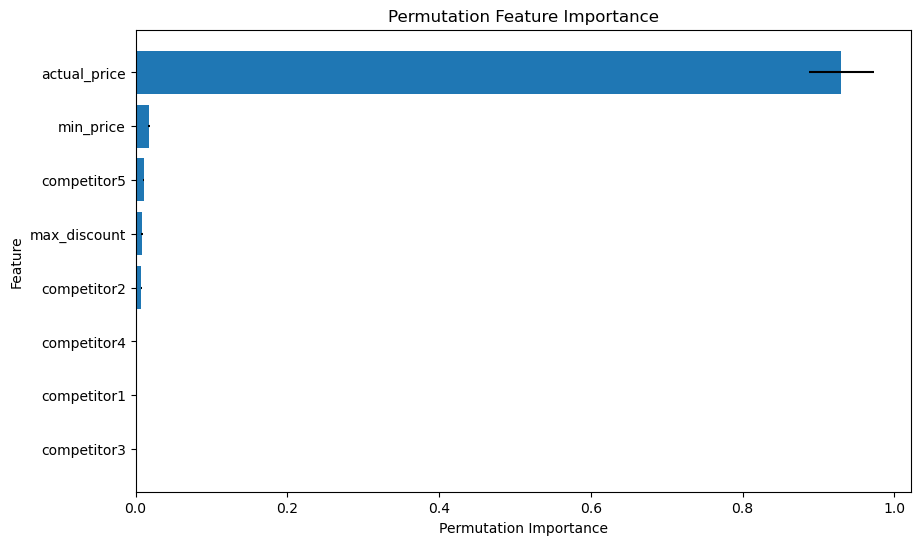

In [60]:
# Feature Importance as a Bar Plot with Error Bars
perm_importance = permutation_importance(base_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for visualization
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Importance STD': perm_importance.importances_std
}).sort_values(by='Importance', ascending=False)

# Plot permutation importance
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], xerr=perm_importance_df['Importance STD'])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [61]:
# Make predictions for the entire dataset
df_predicted = df_final.copy()
df_predicted['max_predicted_price_range'] = np.round(max_price_model.predict(features),2)
df_predicted['min_predicted_price_range'] = np.round(min_price_model.predict(features),2)
df_predicted['base_predicted_price'] = np.round(base_model.predict(features),2)

# Export DataFrame to CSV with predicted promotional price
file_path_with_predictions = 'products_with_predicted_prime.csv'
df_predicted.to_csv(file_path_with_predictions, index=False)

print(f"Data with predicted prime saved to {file_path_with_predictions}")

Data with predicted prime saved to products_with_predicted_prime.csv


In [62]:
# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 12.950559783827071
MSE: 745.4231452934248
RMSE: 27.302438449585868
R^2: 0.9969127248727037


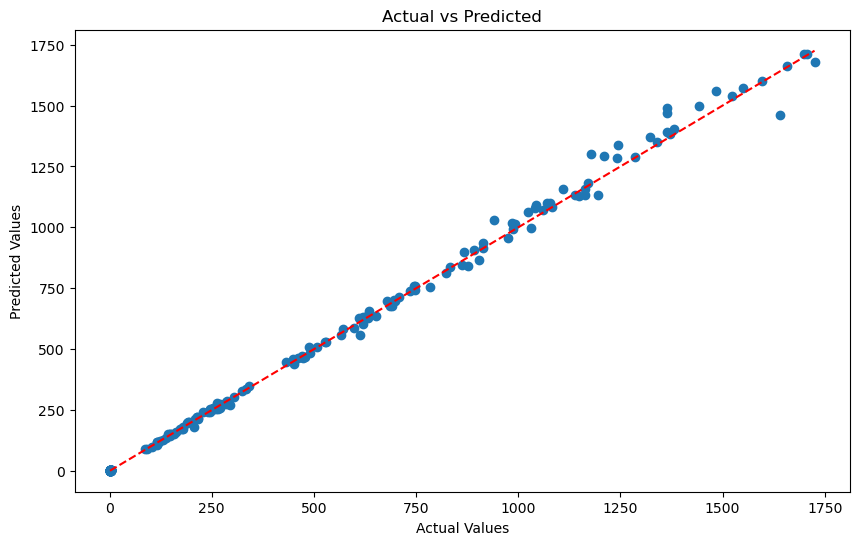

In [63]:
## Actual vs. Predicted Plot

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()

In [ ]:
## Learning Curves

rain_sizes, train_scores, test_scores = learning_curve(base_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Validation error')
plt.ylabel('MSE')
plt.xlabel('Training size')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [ ]:
## Cross-Validation Scores


cv_scores = cross_val_score(base_model, features, target, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print(f"Cross-Validation RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}")

In [ ]:
# Create the modelabs
import pickle

with open('base_model.pkl', 'wb') as f:
    pickle.dump(base_model, f)

with open('min_price_model.pkl', 'wb') as f:
    pickle.dump(min_price_model, f)

with open('max_price_model.pkl', 'wb') as f:
    pickle.dump(max_price_model, f)